In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from unityagents import UnityEnvironment

from inspect import getsource
import torch
import random
from collections import deque

import colorsys

from drl_nav.agent import Agent_PER

In [2]:
path_model = r'./model'
path_result = r'./result'

____

In [3]:
banana_path= r"environment/VisualBanana_Windows_x86_64/Banana.exe"
visual_banana_path= r"environment/VisualBanana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=visual_banana_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 84, 84, 3)
States look like:


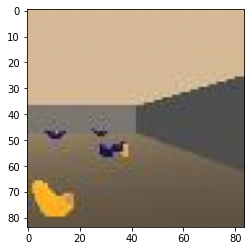

In [83]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
state_size = state.shape
print('States have shape:', state.shape)
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()

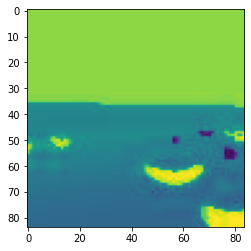

In [7]:
plt.imshow(np.squeeze(state)[:,:,0])

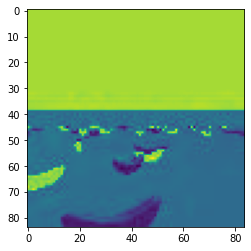

In [94]:
plt.imshow(np.squeeze(state)[:,:,1])

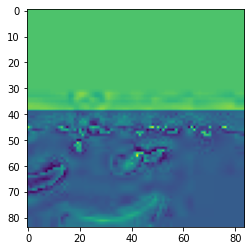

In [95]:
plt.imshow(np.squeeze(state)[:,:,2])


In [8]:
from torch import nn
import torch.nn.functional as F

class ConvBody(nn.Module):
    """
    _summary_

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self):
        super(ConvBody, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5)
        self.mp1 = nn.MaxPool2d(kernel_size=3, stride=3)

    def forward(self, input):
        
        conv = self.conv1(input)
        conv_act = F.relu(conv)
        mp = self.mp1(conv_act)

        return mp
    
class AuxNet(nn.Module):
    
    def __init__(self):
        super(AuxNet, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=4)
    
    def forward(self, x):
        return self.avg_pool(x)

- [X] pooling the image
- [ ] converting the image from RGB to HSV in order to make the 3 image dimension independent.
- [ ] checking Hue range in HSV

#### Preprocessing with Auxiliary network

from


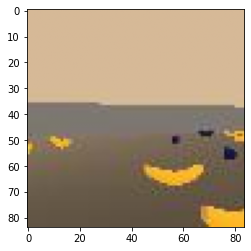

In [9]:
print('from')
plt.imshow(np.squeeze(state));

into


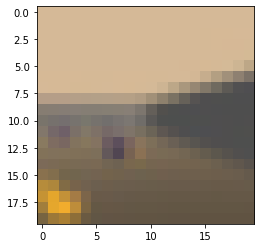

In [85]:
net = ConvBody()
aux_net= AuxNet()

state_torch = torch.from_numpy(np.squeeze(state).T).float()

output = aux_net(state_torch)
output_rgb = output.numpy().T

print('into')
plt.imshow(output_rgb);

### Finding colored bananas.

In [21]:
output_rgb.shape # 20 * 20 pixels RGB size 3

(20, 20, 3)

##### Converting RGB to HSV images.

In [11]:
def rgb_to_hsv(args):
    return colorsys.rgb_to_hsv(*args)
def hsv_to_rgb(args):
    return colorsys.hsv_to_rgb(*args)

checks

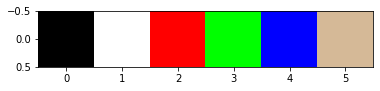

In [12]:
x_RGB = np.array([
    [
        [0.,0.,0.],
        [1.,1.,1.],
        [1.,0.,0.],
        [0.,1.,0.],
        [0.,0.,1.],
        [0.8392152 , 0.72549045, 0.59215695]
    ]
])

# test image
plt.imshow(x_RGB)

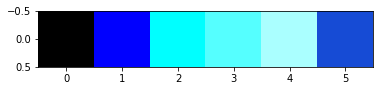

In [13]:
# to HSV
x_HSV = np.apply_along_axis(rgb_to_hsv, 2, x_RGB)
plt.imshow(x_HSV);

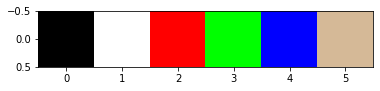

In [14]:
# back to RGB
x_RBG_back = np.apply_along_axis(hsv_to_rgb, 2, x_HSV)
plt.imshow(x_RBG_back)

##### Finding the Hue range

In [15]:
def plot_hue_color_range(hue_range, nbr_points=11):
    """
    plot the colors between the given min and max hue.
    """
    
    min_hue, max_hue = hue_range
    hues = np.linspace(min_hue, max_hue, nbr_points)
    x_HSV = np.expand_dims([[hue, .9, .9] for hue in hues], axis=0)
    x_RGB = np.apply_along_axis(hsv_to_rgb, 2, x_HSV)
    
    _, ax = plt.subplots(1,1)
    img = ax.imshow(x_RGB)
    ax.set_xticks(np.linspace(0, len(hues)-1, len(hues)))
    ax.set_xticklabels(np.round(hues, 2));
    ax.set_yticklabels('');

Checks

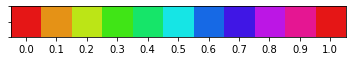

In [16]:
plot_hue_color_range((0,1))

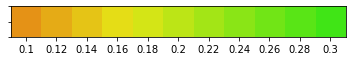

In [17]:
plot_hue_color_range((0.1,.3))

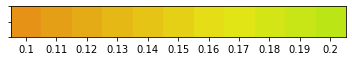

In [53]:
plot_hue_color_range((0.1,.2))

yellow range => [0.1, 0.2]

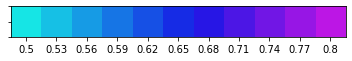

In [96]:
plot_hue_color_range((.5,.8))

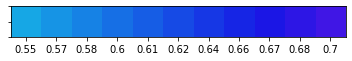

In [100]:
plot_hue_color_range((.55,.7))

blue range => [0.55, 0.7]

In [151]:
def is_yellow(hsv):
    hue = hsv[0]
    return (.11 <= hue) & (hue <= .2)

def is_blue(hsv):
    hue = hsv[0]
    return (.55 <= hue) & (hue <= .7)

##### Checks

In [148]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]

state_rgb =  np.squeeze(state)
state_hsv = np.apply_along_axis(rgb_to_hsv, 2, state_rgb)

state_torch = torch.from_numpy(np.squeeze(state).T).float()
output = aux_net(state_torch)

output_rgb = output.numpy().T
output_hsv = np.apply_along_axis(rgb_to_hsv, 2, output_rgb)

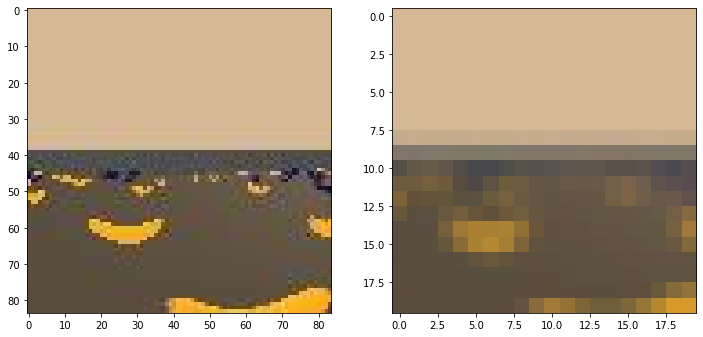

In [149]:
_, (ax1, ax2) = plt.subplots(1,2, figsize = (12,10))

ax1.imshow(state_rgb)
ax2.imshow(output_rgb)

plt.show()

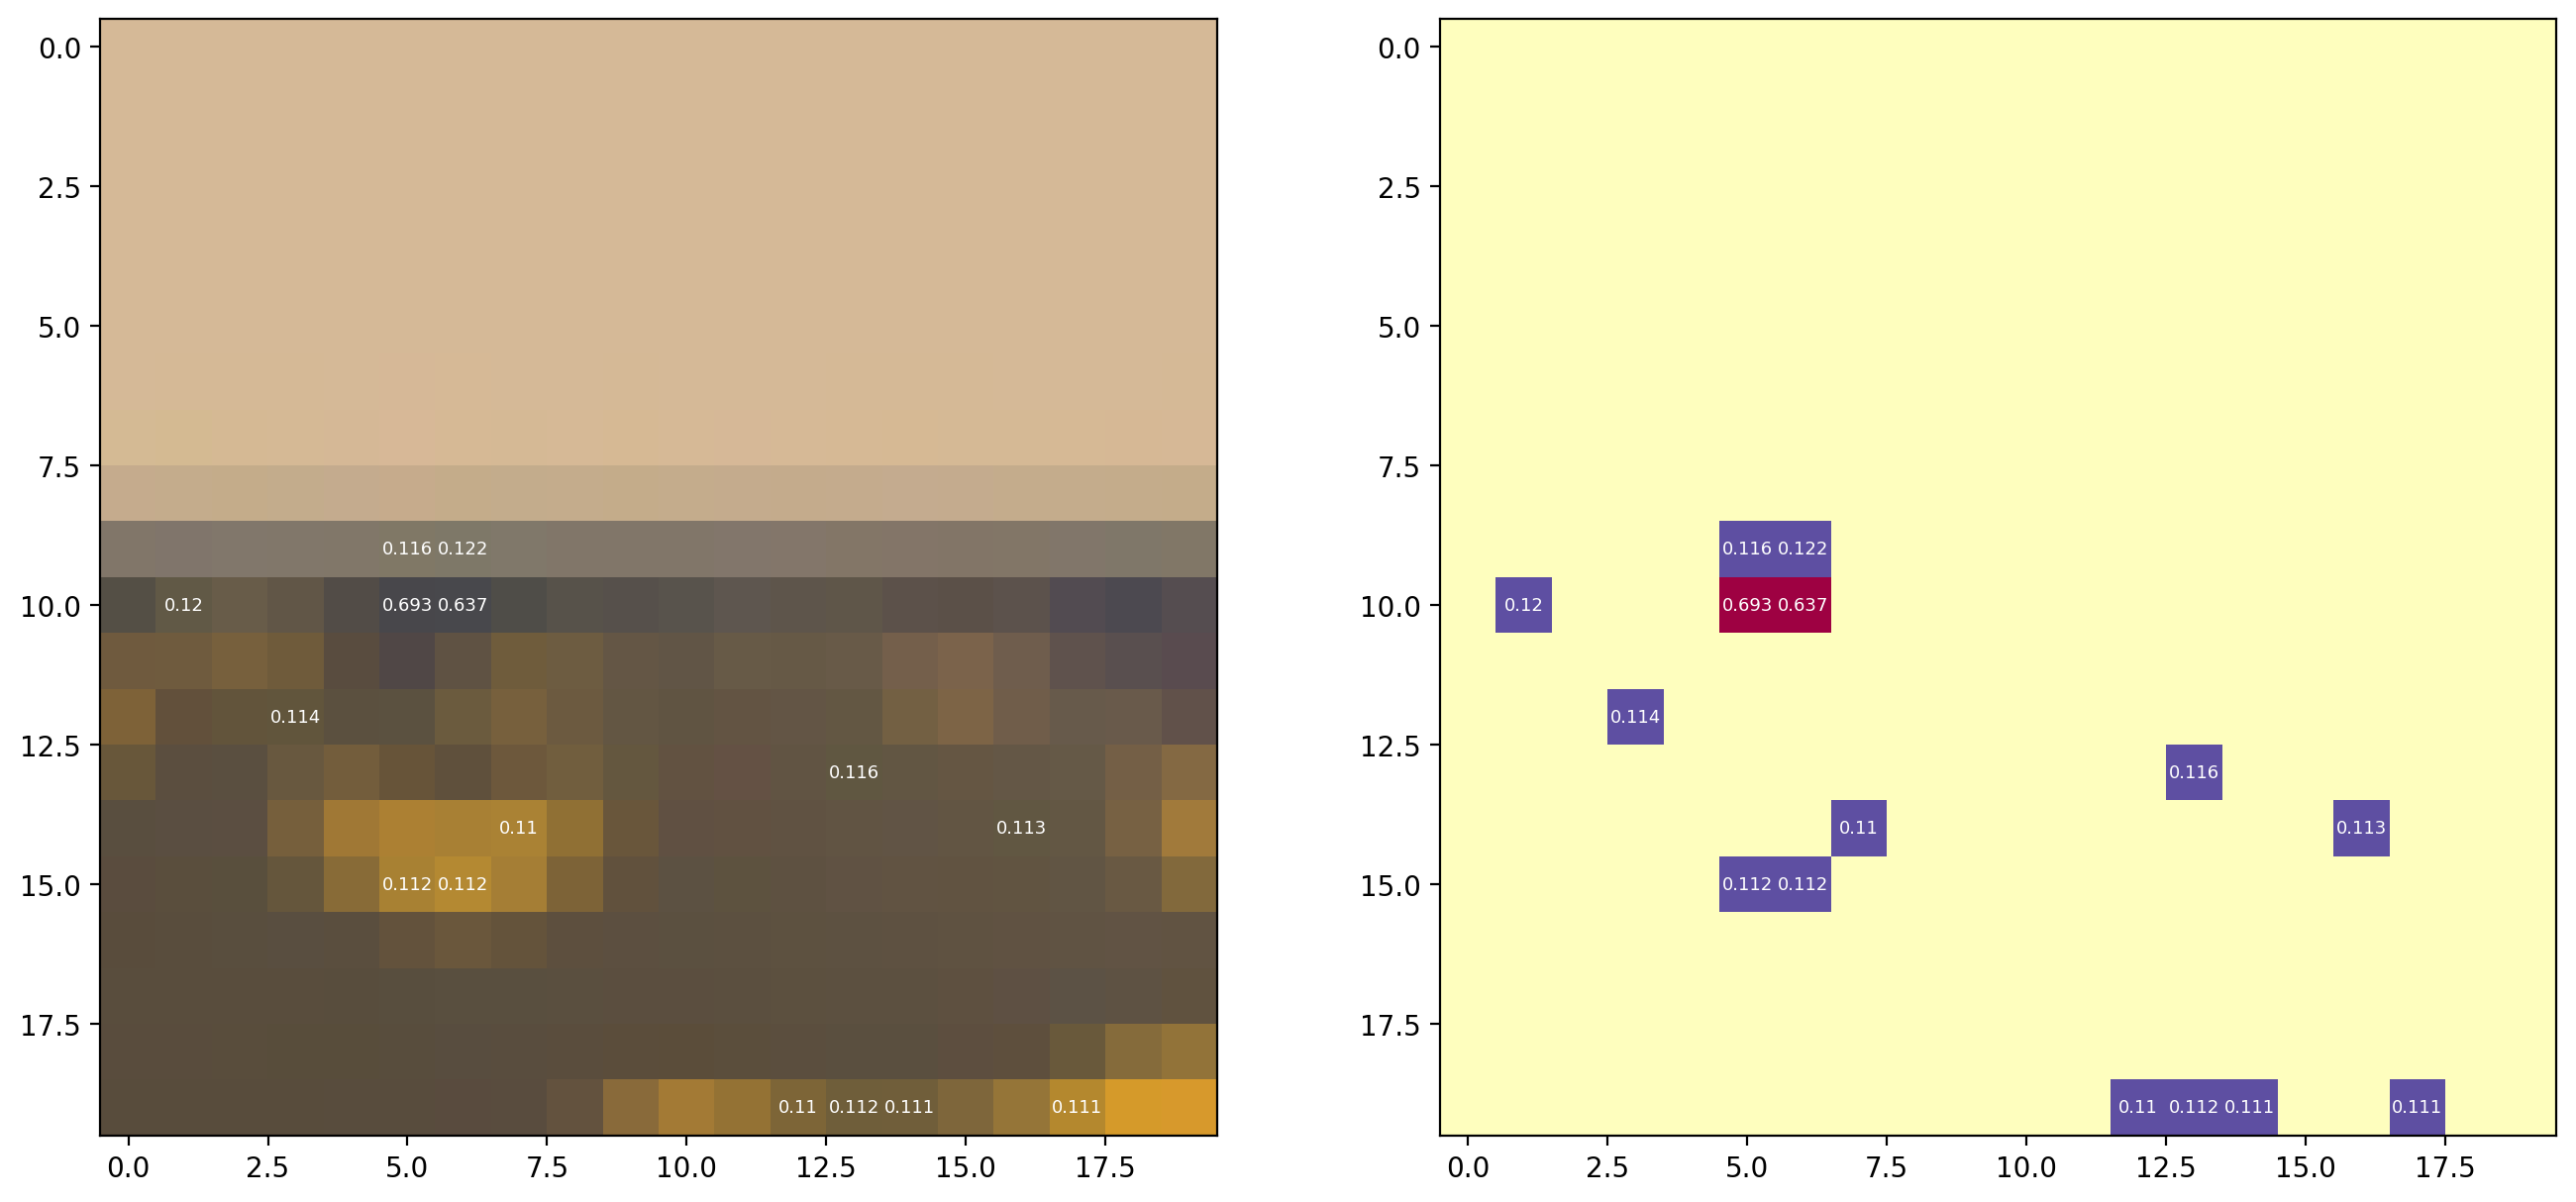

In [154]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)

ax1.imshow(output_rgb)
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

plt.show()

Yellow is not working, analyzing the different hues.

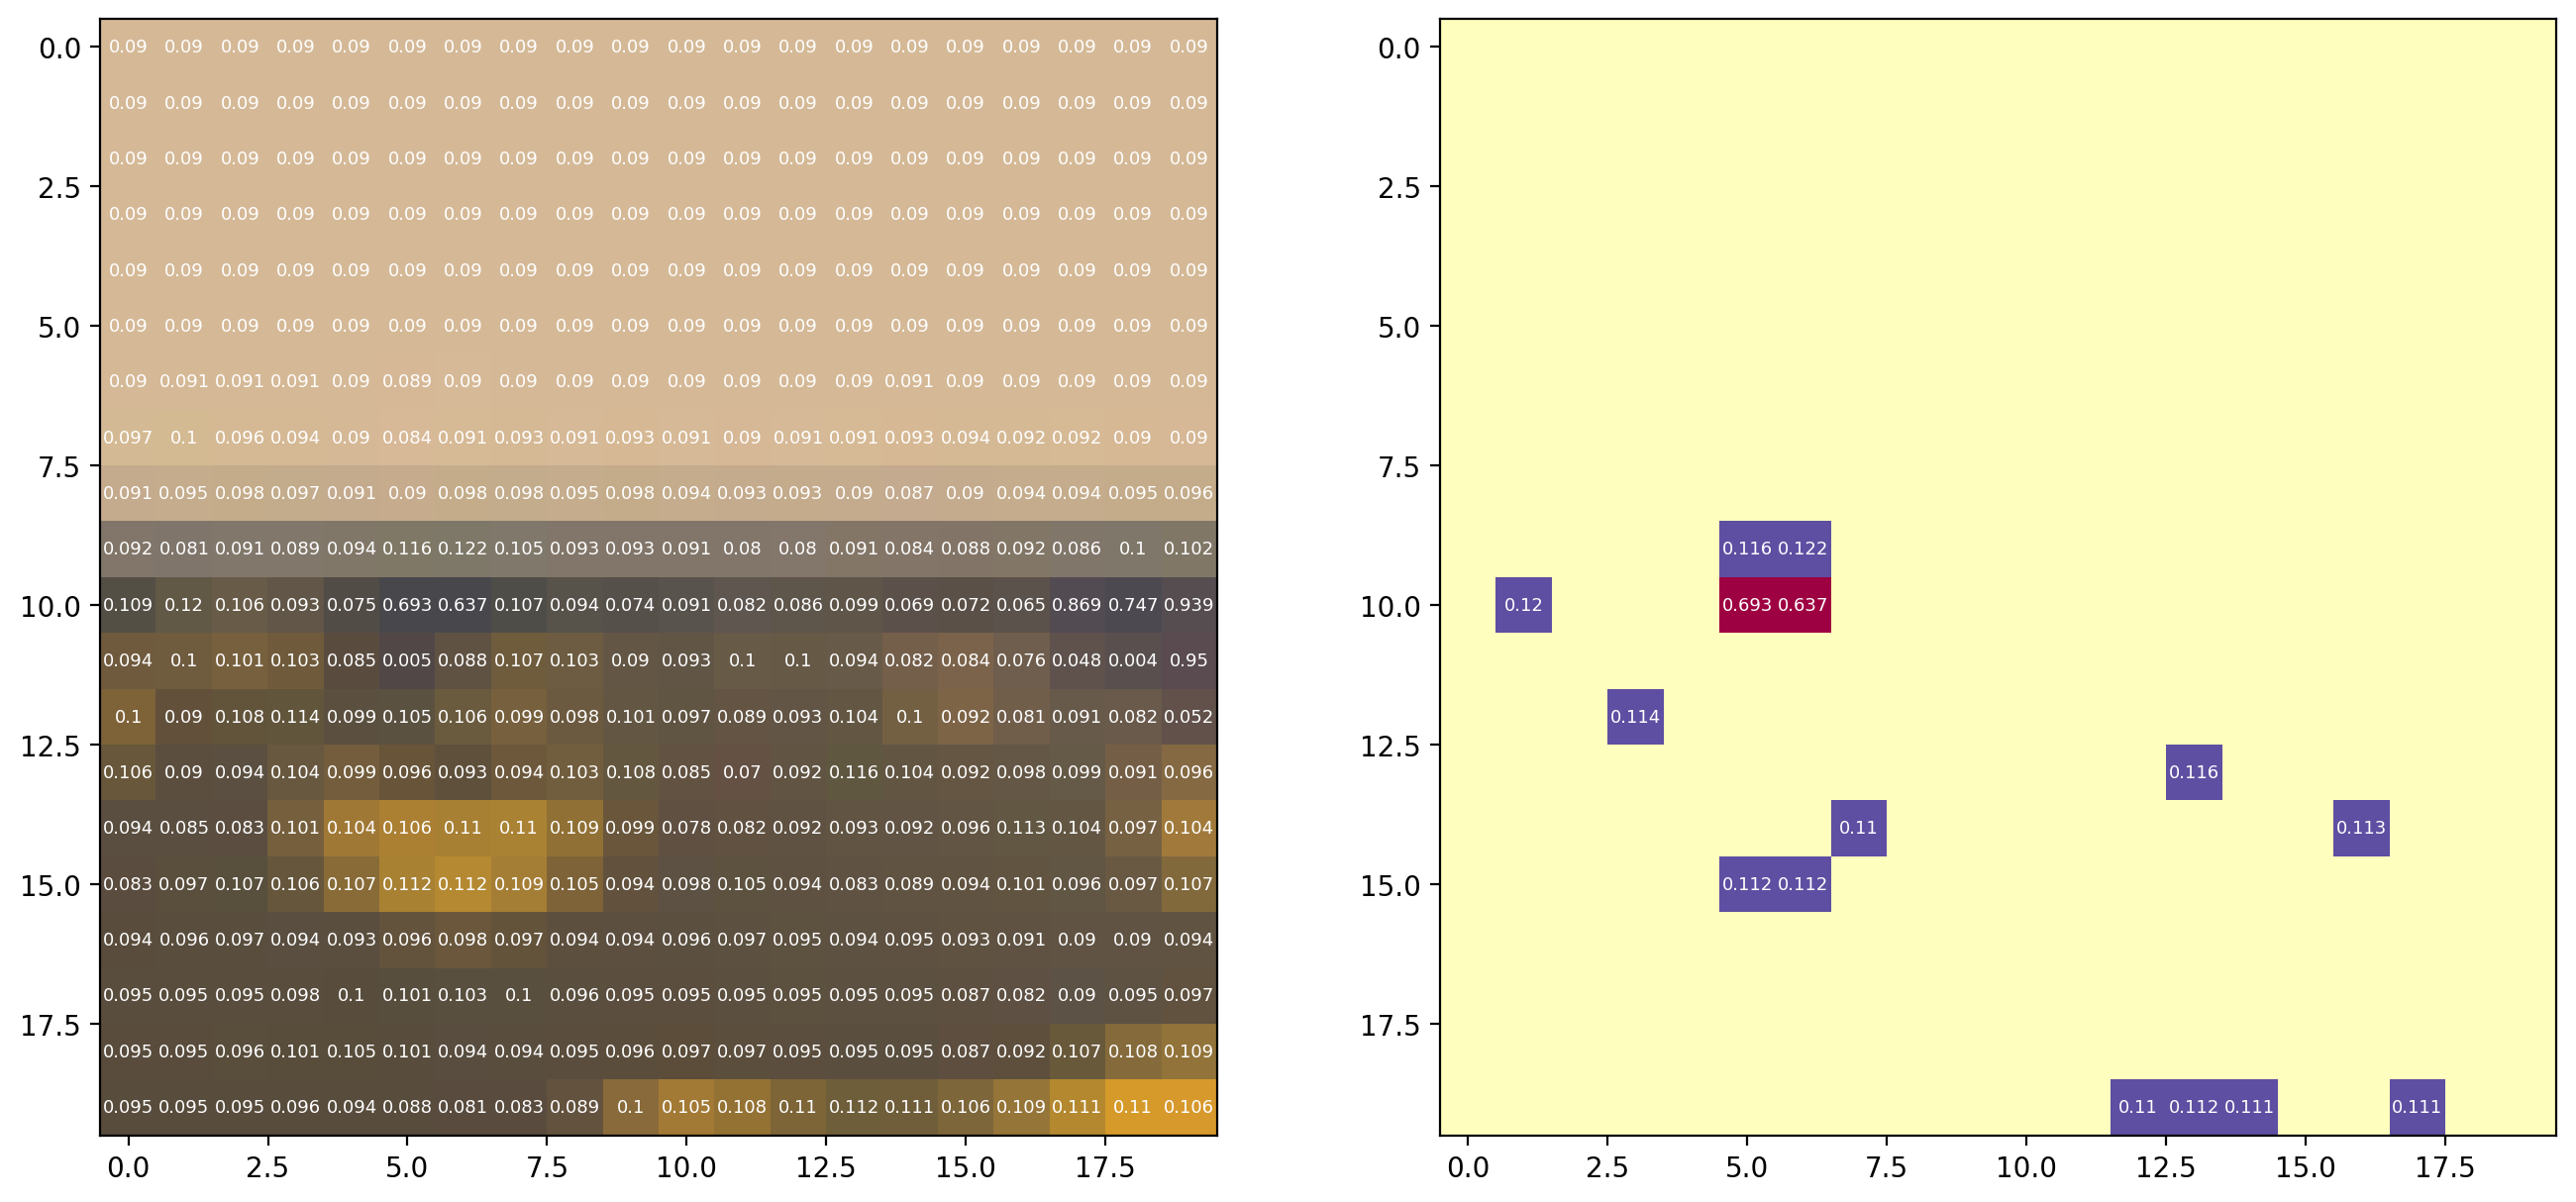

In [155]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)
ax1.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

ax1.imshow(output_rgb)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

plt.show()

Analyzing HSV data on a yellow sample to find complementary characteristics.

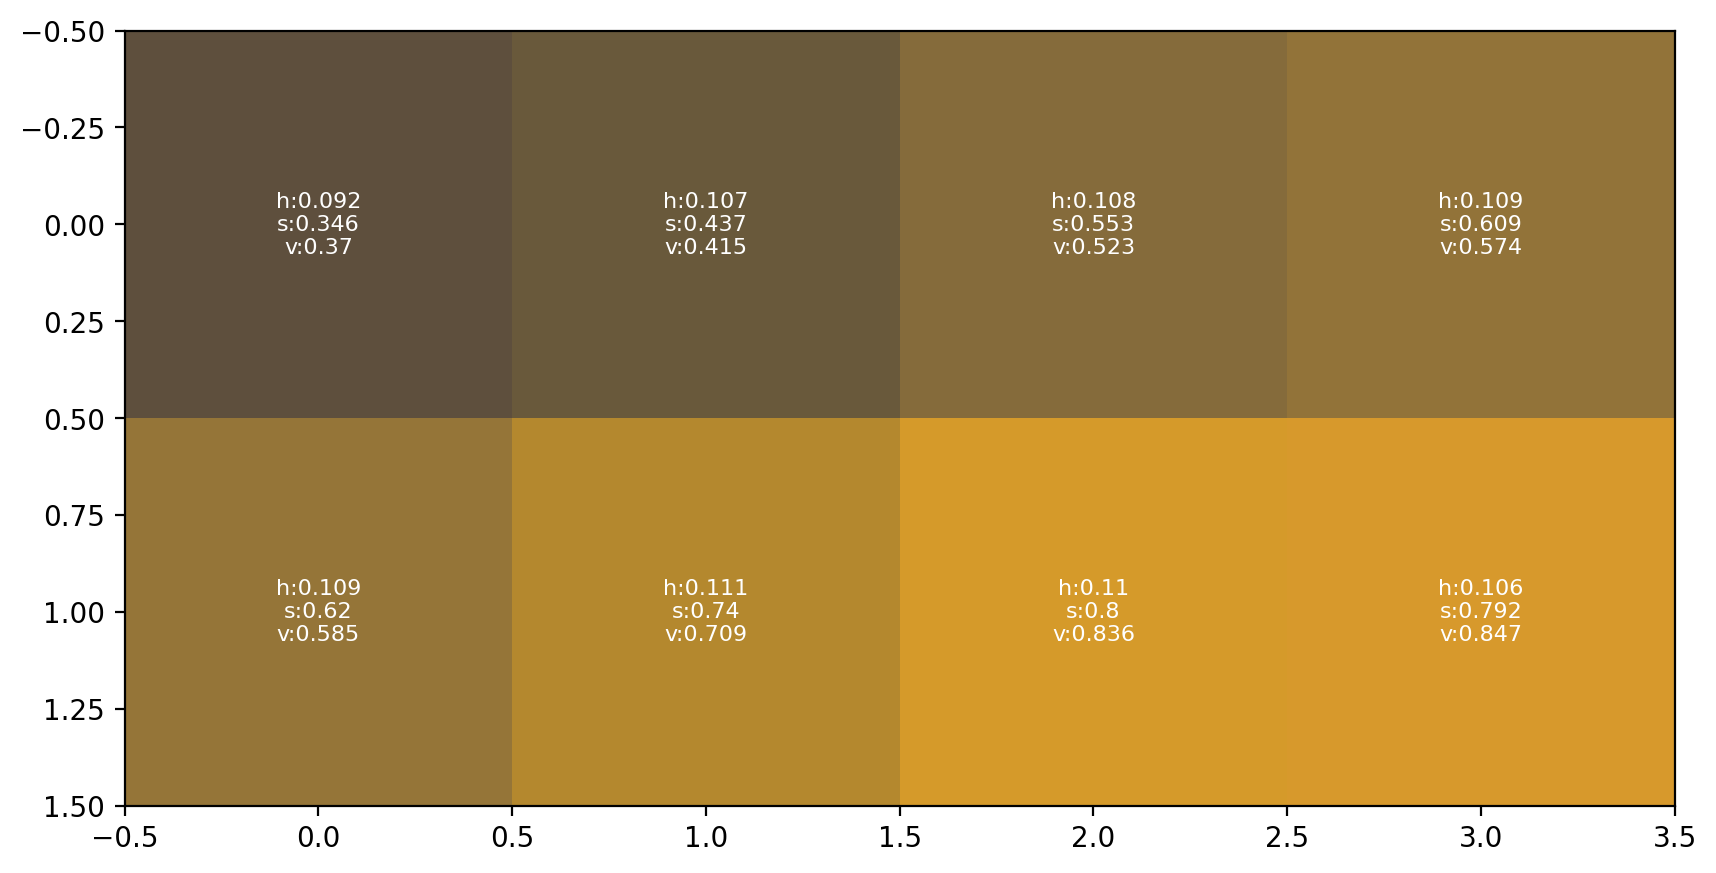

In [164]:
_, ax = plt.subplots(1,1, figsize = (10,6), dpi=200)

yellows_sample_rgb = output_rgb[18:20, 16:20]
yellows_sample_hsv = state_hsv = np.apply_along_axis(rgb_to_hsv, 2, yellows_sample_rgb)

ax.imshow(yellows_sample_rgb)

for i in range(yellows_sample_rgb.shape[0]):
    for j in range(yellows_sample_rgb[i].shape[0]):
        ax.text(j, i, 
                (f'h:{np.round(yellows_sample_hsv[i, j, 0], 3)}\n'+
                 f's:{np.round(yellows_sample_hsv[i, j, 1], 3)}\n'+
                 f'v:{np.round(yellows_sample_hsv[i, j, 2], 3)}'),
                ha="center", va="center", color="w", fontsize=8)


plt.show()

In [189]:
def is_yellow(hsv):
    
    hue = hsv[0]
    sat = hsv[1]
    val = hsv[2]
    
    hue_ok = ((.105 <= hue) & (hue <= .2))
    sat_ok = .6 <= sat
    val_ok = .6 <= val
    
    return hue_ok & sat_ok & val_ok

def is_blue(hsv):
    hue = hsv[0]
    return (.55 <= hue) & (hue <= .7)

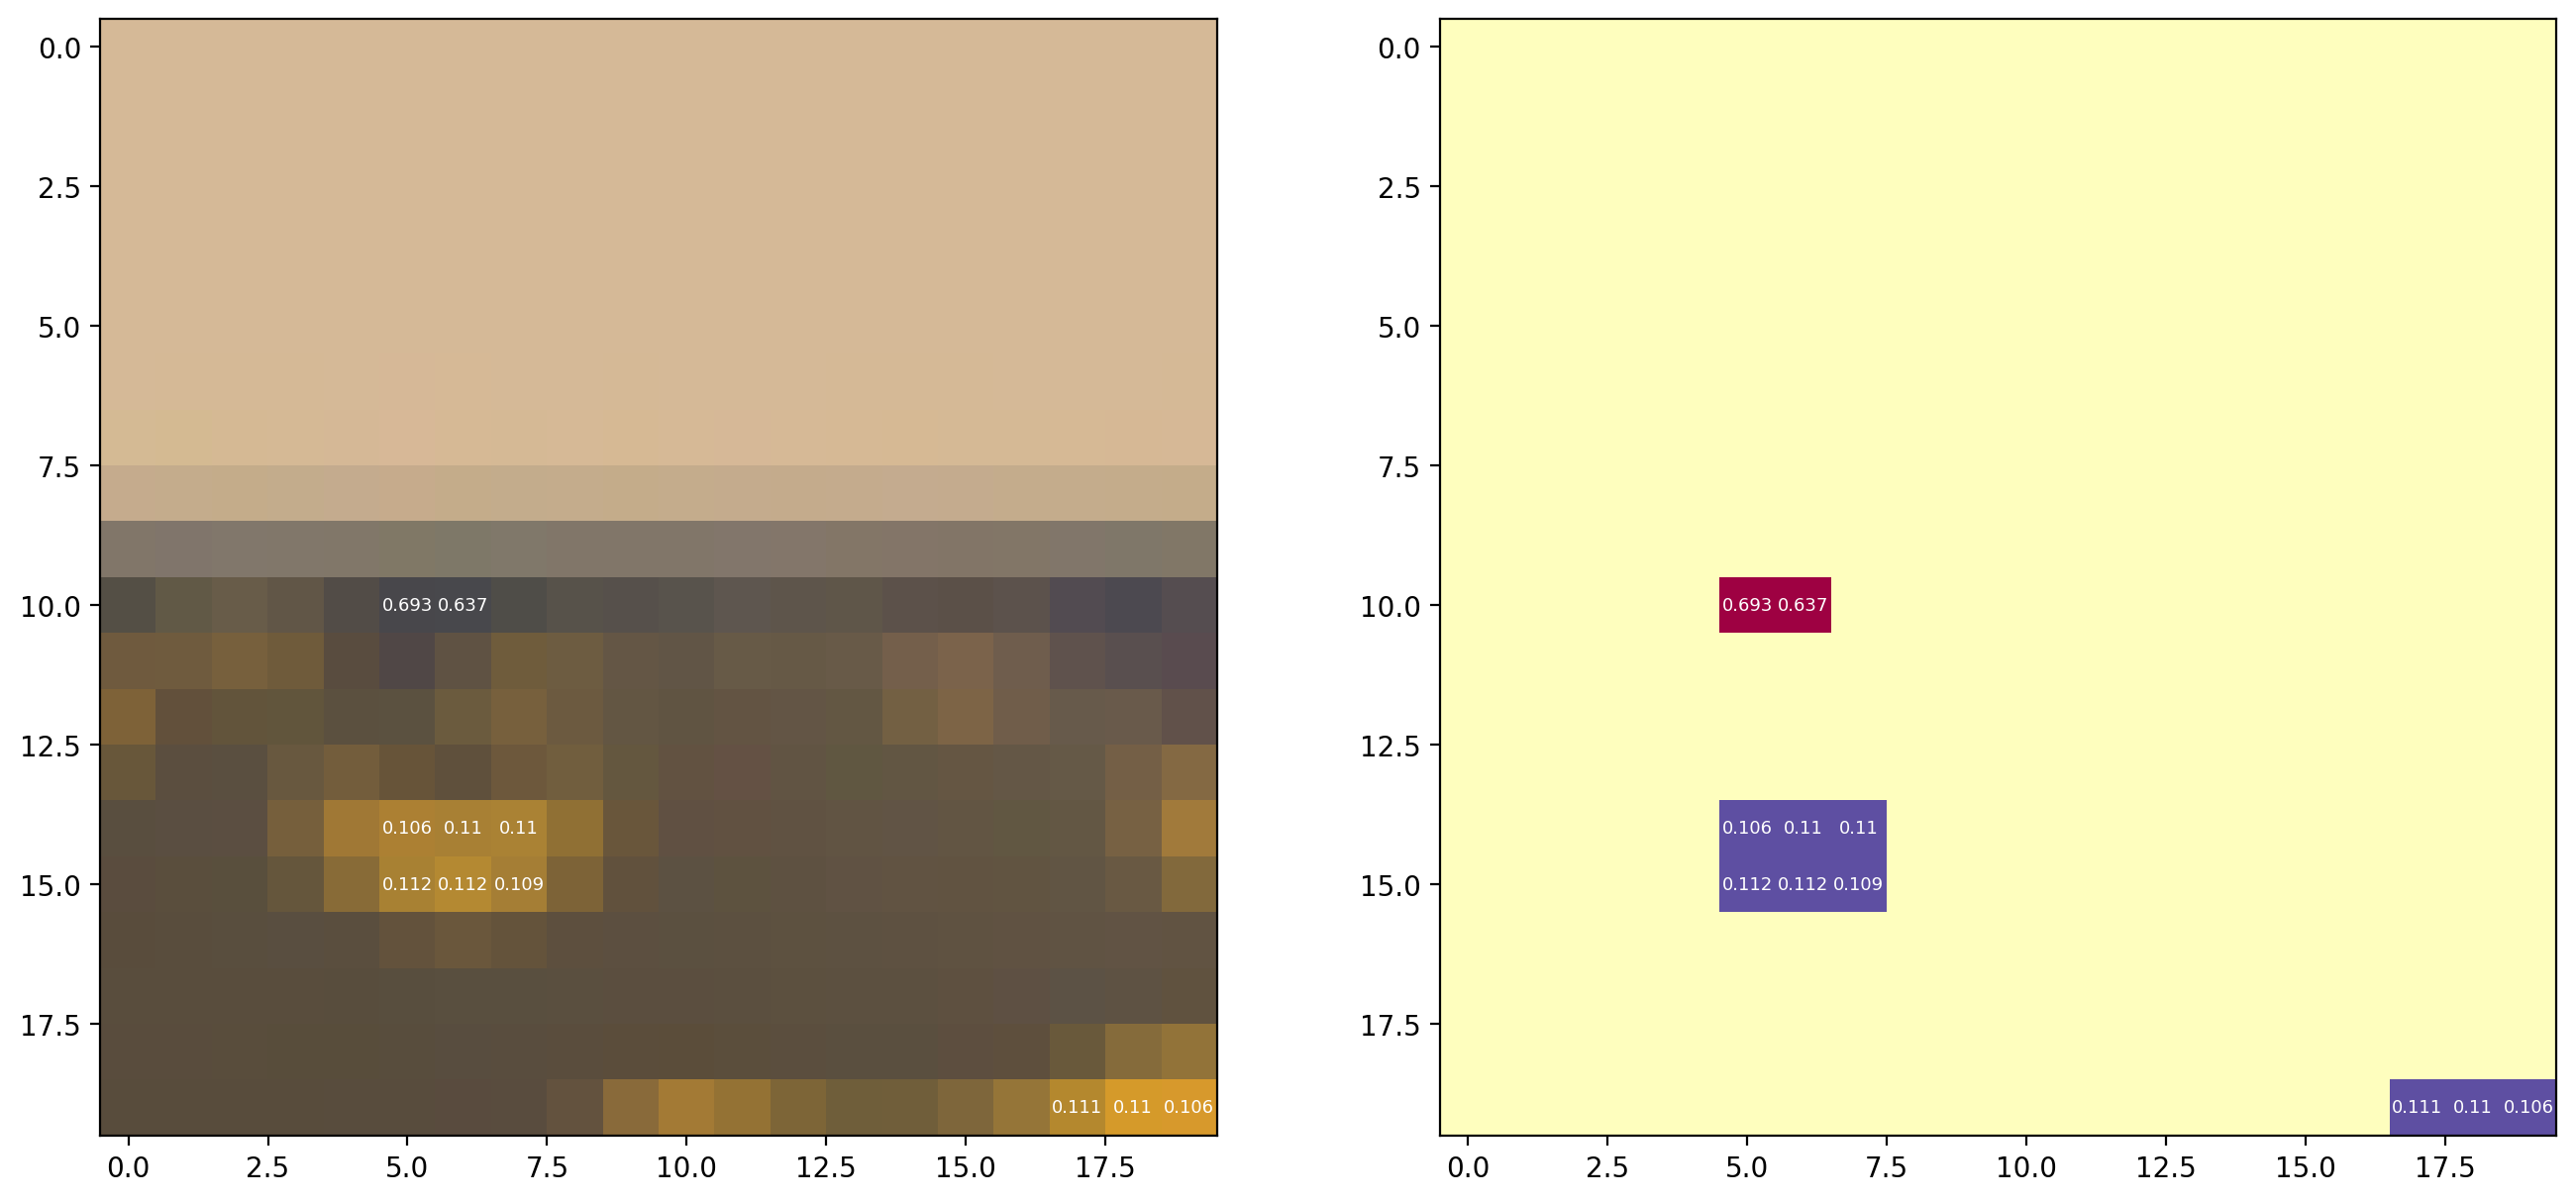

In [190]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)

ax1.imshow(output_rgb)
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

plt.show()

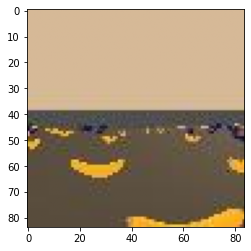

In [191]:
plt.imshow(state_rgb)

__________
#### One episode

In [22]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]          
score = 0                                        

while True:
    
    action = np.random.choice([0,1,2,3])         
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    #agent.step(state, action, reward, next_state, done) 
    
    score += reward                               
    state = next_state  
    
    if done:                                      
        break
    
print("Score: {}".format(score))

Score: 0.0
